# Topic Modelによる類似文献の提示手法について
@date 2019.08.14  
@author Kenta Matsui  


## 参考文献
[1] https://www.aclweb.org/anthology/W14-3110


## ライブラリのインポート

In [1]:
import time
from datetime import datetime
import pickle
import logging
from collections import Counter
from pprint import pprint

import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
import pandas as pd

# Natural Language Processing Libraries
import gensim
from gensim import similarities     
from gensim.test.utils import get_tmpfile, common_texts
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Vizualization
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# Local
from topic_model import TopicModel
from error_definition import Result

import warnings
warnings.filterwarnings('ignore')

## Topic modelの初期化

トピック数はハイパーパラメタなので、学習では決まらない。色々なトピック数を試してみて、学習が一番「うまくいった」ときの値を最適な値として使うことはできる。

In [2]:
# ラッパークラスの初期化
topic_model = TopicModel(logger_level=logging.WARN )

# nltkライブラリのデータをダウンロード
# stopwordsや前処理要データを落としてくる
topic_model.load_nltk_data()

# デバッグ用にarxivsから論文のabstractを使う
df = pd.read_csv("./arxivs_data.csv")
topic_model.create_corpus_from_df(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/MiniBell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/MiniBell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/MiniBell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Topic modelの学習
色々パラメータがあるが、あまり調整できるようにはしていない。
MALLETのLDAだと不要に見える。ただ、学習語のMarginal Topic Distoributionが各トピックで均一すぎない？

どれだけ学習がうまくいっているかの指標として、Perplexityがある。これが小さな値となっていれば、うまく学習できていると言える。  （ランダムに単語を生成するのではなく、文書に現れる単語を限られた単語の中から選ぶ方が良いモデル（汎化性能が高い）だと言えるので、Perplexityが小さいほど良いモデル(汎化性能が高い)だと言える。）  

また、Coherenceも指標として用いることができる。こちらは0~1の値をとり、大きくなるほど良い学習結果と言える。  

gensimのMALLETのwrapperがPerplexityを計算する関数を持っていない買ったので、今回はcoherenceを指標とする。

In [3]:
# トピック数を決める
topic_model.set_num_topics(15)

# 学習の開始
topic_model.train_mallet(num_pass=20)

scanning corpus to determine the number of features (consider setting `num_features` explicitly)


<Result.SUCCESS: 6>

In [4]:
pprint(topic_model.get_model_info())
num_all_words = len(topic_model.dictionary)
perplexity = topic_model.calc_perplexity()
coherence = topic_model.calc_coherence()
print("Perplexity = " + str(perplexity))
print("Perplexity / Num_total_words =  " + str(perplexity/num_all_words))
print("Coherence = " + str(coherence))

{'date': datetime.datetime(2019, 8, 14, 23, 32, 35, 238286),
 'num_docs': 15000,
 'num_topics': 15}
Perplexity = nan
Perplexity / Num_total_words =  nan
Coherence = 0.4571028470534982


In [5]:
vis = pyLDAvis.gensim.prepare(topic_model.lda, topic_model.corpuses, topic_model.dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
0      6.766565        1       1  0.034030 -0.063909
1      6.554898        1       2 -0.044004  0.294429
2      6.410814        1       3 -0.034694 -0.146260
3      6.455174        1       4 -0.041900 -0.162582
4      6.454862        1       5 -0.000742 -0.002023
5      6.757997        1       6 -0.072277  0.082617
6      6.398831        1       7 -0.128431  0.089653
7      7.250624        1       8  0.322775 -0.065089
8      7.335425        1       9 -0.162436 -0.185816
9      6.650771        1      10 -0.083126  0.297218
10     7.147705        1      11 -0.184925 -0.108492
11     6.309568        1      12  0.198344  0.087494
12     6.542078        1      13  0.285611 -0.059755
13     6.366521        1      14  0.054647  0.038973
14     6.598167        1      15 -0.142872 -0.096457, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
7717   Default  15561.000000           model  15561.000000  30.0000  30.0000
13946  Default  11683.000000            data  11683.000000  29.0000  29.0000
6404   Default  12942.000000         network  12942.000000  28.0000  28.0000
14408  Default   9931.000000       algorithm   9931.000000  27.0000  27.0000
6230   Default  10230.000000         problem  10230.000000  26.0000  26.0000
18658  Default  10876.000000          method  10876.000000  25.0000  25.0000
24134  Default   9785.000000          system   9785.000000  24.0000  24.0000
27751  Default   6322.000000           image   6322.000000  23.0000  23.0000
32902  Default   6027.000000           learn   6027.000000  22.0000  22.0000
23708  Default   4376.000000           graph   4376.000000  21.0000  21.0000
12417  Default   3857.000000        function   3857.000000  20.0000  20.0000
18673  Default   4755.000000            user   4755.000000  19.0000  19.0000
29766  Default   4772.000000            task   4772.000000  18.0000  18.0000
16551  Default  11837.000000         propose  11837.000000  17.0000  17.0000
13620  Default   3728.000000          neural   3728.000000  16.0000  16.0000
1914   Default   3394.000000            deep   3394.000000  15.0000  15.0000
1342   Default   4519.000000         feature   4519.000000  14.0000  14.0000
29143  Default   3154.000000        learning   3154.000000  13.0000  13.0000
22447  Default   7678.000000            time   7678.000000  12.0000  12.0000
1039   Default   3915.000000        analysis   3915.000000  11.0000  11.0000
29653  Default   2711.000000            code   2711.000000  10.0000  10.0000
610    Default   7823.000000        approach   7823.000000   9.0000   9.0000
6213   Default   2710.000000           train   2710.000000   8.0000   8.0000
8346   Default   2794.000000           space   2794.000000   7.0000   7.0000
6121   Default   6022.000000     performance   6022.000000   6.0000   6.0000
24007  Default   2480.000000          object   2480.000000   5.0000   5.0000
1997   Default   5041.000000             set   5041.000000   4.0000   4.0000
27307  Default   2357.000000    distribution   2357.000000   3.0000   3.0000
2225   Default   2761.000000           bound   2761.000000   2.0000   2.0000
26008  Default   4593.000000           study   4593.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
20896  Topic15   1171.766025        semantic   1236.475243   2.6646  -4.4337
9483   Topic15   1009.353804       attention   1094.951297   2.6370  -4.5829
13223  Topic15   1648.102539        sequence   1869.362110   2.5924  -4.0926
16199  Topic15   1890.085848        language   2210.082316   2.5620  -3.9556
30784  Topic15   1084.564832        question   1253.602149   2.5735  -4.5110
25550  Topic15    672.539197          answer    747.764420   2.6124  -4.9889
22197  Topic15    763.010435           score    892.6

In [8]:
similar_doc_ind = None

idx = 18003
doc  = df.iloc[ind]["abstract"]
topic_model.add_doc(doc, idx=idx)

recommended_ids = topic_model.recommend_from_id_(idx, num_similar_docs=10)
similar_doc_idx = recommended_ids[1]
for ridx in recommended_ids:
    print("[recommend ]" + str(ridx))

Add new document on corpus and topic distoribution indecies.
[recommend ]18003
[recommend ]10433
[recommend ]8223
[recommend ]512
[recommend ]885
[recommend ]13854
[recommend ]8572
[recommend ]9511
[recommend ]3536
[recommend ]636


Text(0.5, 1.0, 'Document ID: 10433')

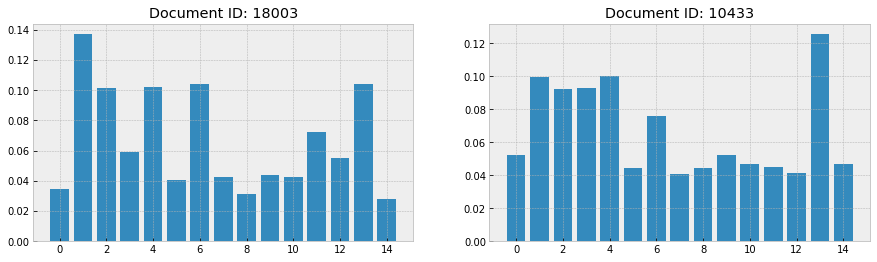

In [9]:
doc  = df.iloc[idx]["abstract"]
corpus = topic_model.corpus_from_doc(doc)
topic_distoribution = topic_model.lda.get_document_topics(corpus)

fig = plt.figure(figsize=(15, 4 ))
plt.style.use('bmh')

ax1 = fig.add_subplot(1, 2, 1)
ax1.bar([e[0] for e in topic_distoribution], [e[1] for e in topic_distoribution])
ax1.set_title("Document ID: " + str(idx))

ax2 = fig.add_subplot(1, 2, 2)
doc  = df.iloc[similar_doc_idx]["abstract"]
corpus = topic_model.corpus_from_doc(doc)
topic_distoribution = topic_model.lda.get_document_topics(corpus)
ax2.bar([e[0] for e in topic_distoribution], [e[1] for e in topic_distoribution])
ax2.set_title("Document ID: " +  str(similar_doc_idx))

In [11]:
# Target
# ind = 18000 
doc  = df.iloc[idx]["abstract"]
topic_model.add_doc(doc, idx=idx)

print("* Target document: ")
print(doc)
print("----")

# Similar 
similar_doc  = df.iloc[similar_doc_idx]["abstract"]

print("* Similar document: ")
print(similar_doc)
print("----")

[Error] There is the same ID in corpus.
* Target document: 
in contrast to electronic computation, chemical computation is noisy and susceptible to a variety of sources of error, which has prevented the construction of robust complex systems. to be effective, chemical algorithms must be designed with an appropriate error model in mind. here we consider the model of chemical reaction networks that preserve molecular count (population protocols), and ask whether computation can be made robust to a natural model of unintended "leak" reactions. our definition of leak is motivated by both the particular spurious behavior seen when implementing chemical reaction networks with dna strand displacement cascades, as well as the unavoidable side reactions in any implementation due to the basic laws of chemistry. we develop a new "robust detection" algorithm for the problem of fast (logarithmic time) single molecule detection, and prove that it is robust to this general model of leaks. besides pot

## Topic数の最適化


In [9]:
topic_nums = [5, 10, 15, 20, 25]
history = []

for n in topic_nums:
    
    topic_model.set_num_topics(n)
    
    # 学習の開始
    topic_model.train(num_pass=10)

    # 結果の格納
    history.append(topic_model.calc_coherence())

scanning corpus to determine the number of features (consider setting `num_features` explicitly)
scanning corpus to determine the number of features (consider setting `num_features` explicitly)
scanning corpus to determine the number of features (consider setting `num_features` explicitly)
scanning corpus to determine the number of features (consider setting `num_features` explicitly)
scanning corpus to determine the number of features (consider setting `num_features` explicitly)


In [14]:
df.head(1 )

,index,id,title,categories,abstract,doi,created,updated,authors,category,cat0,cat1,cat2
0,13476,1710.02076,on the effective use of pretraining for natura...,cs.cl,neural networks have excelled at many nlp task...,NaN,2017-10-05,NaN,"['cases', 'luong', 'potts']",cs.cl,cs.cl,NaN,NaN


In [15]:
for x in dir(topic_model):
    print(x)

__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__str__
__subclasshook__
__weakref__
_simplify
add_doc
calc_best_topic_from_id
calc_coherence
calc_perplexity
calc_topic_distribution_from_corpus
calc_topic_distribution_from_doc
corpus
corpus_from_doc
create_corpus_from_df
create_eta
create_topic_distributions_from_curposes
df
dictionary
disp_topic_distribution
disp_topic_words
doc_ids
doc_index_similarity
doc_mat_similarity
get_corpus_from_id
get_model_info
get_topic_terms
get_unused_texts
get_used_texts
is_model_trained
lda
liked_doc_ids
load_model
load_nltk_data
model_create_datetime
num_docs
num_topics
preprocess
recommend_from_doc
recommend_from_id
recommend_from_id_
save_lda_vis_as_html
save_model
set_num_topics
set_topic_distribution_index
set_topic_distribution_matrix
set_topic_distribution_own_matrix
stopwords
texts
to

## 単体テストの準備

In [2]:
from gensim.models import word2vec
from gensim.test.utils import get_tmpfile,  common_texts, common_dictionary, common_corpus

In [3]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [4]:
lda =gensim.models.LdaModel(common_corpus, id2word=common_dictionary, num_topics=3, random_state=100)

In [24]:
mallet_path = "./mallet-2.0.8/bin/mallet"  
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, common_corpus, id2word=common_dictionary, num_topics=3, random_seed=1)# , iterations=10)
lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)

In [28]:
lda.get_document_topics(common_corpus[0])

[(0, 0.3144654088050315), (1, 0.34276731911127534), (2, 0.342767272083693)]

In [7]:
new_text= ["iphone", "interface","system", "human"]

In [8]:
new_corpus = common_dictionary.doc2bow(new_text)

In [9]:
lda.get_document_topics(new_corpus)

[(0, 0.33333333333333337), (1, 0.3435875053601196), (2, 0.32307916130654707)]